In [179]:
import pandas as pd
import numpy as np
import os
import json
import glob
from scipy import stats
import matplotlib.pyplot as plt
import spacy
from sklearn.metrics import mean_squared_error
from math import sqrt
from operator import itemgetter
from yellowbrick.text import TSNEVisualizer

# Download data from Kaggle and load

In [2]:
root = 'C:/Users/brian/Documents/GitHub/COVID19_RESEARCH/data'
meta_path = os.path.join(root, 'metadata.csv')

meta_df = pd.read_csv(meta_path)
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


# Clean the data for processing

In [3]:
meta_df.shape

(52398, 18)

In [4]:
meta_df = meta_df[['cord_uid', 'title', 'abstract', 'publish_time', 'authors', 'url']]
meta_df.isnull().sum()

cord_uid           0
title            158
abstract        9230
publish_time       8
authors         2279
url              302
dtype: int64

In [5]:
meta_df = meta_df.dropna(subset=['title', 'abstract'])
meta_df.shape

(43019, 6)

In [6]:
check_duplicates = ['cord_uid','title', 'abstract', 'authors']

for head in check_duplicates:
    meta_df = meta_df.drop(meta_df[meta_df[f'{head}'].duplicated()].index)

#Check duplicates are empty
[(meta_df[meta_df[f'{head}'].duplicated()]) for head in check_duplicates]


[Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: []]

In [7]:
meta_df.shape

(41125, 6)

In [8]:
text = meta_df

In [9]:
index, value = zip(*[(index, len(val)) for index, val in enumerate(text['abstract'])])
docs_length= pd.Series(value, index)                      

Text(0, 0.5, 'Frequency')

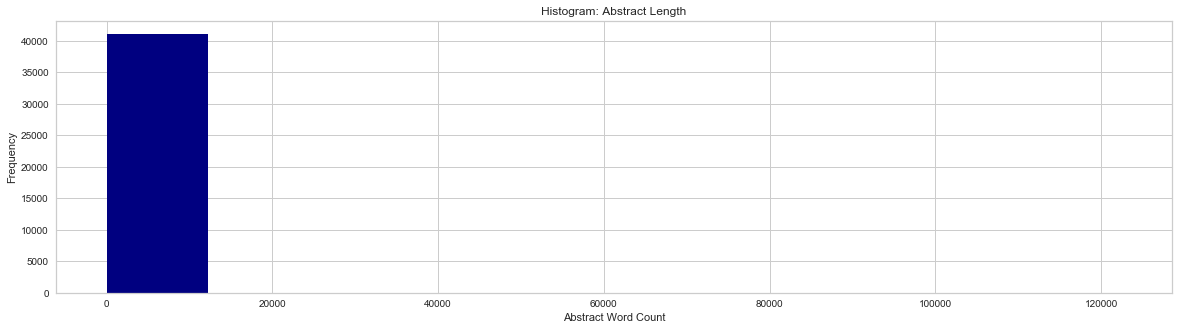

In [10]:
doc_length = docs_length.plot(kind = 'hist', title = 'Histogram: Abstract Length', colormap='jet', figsize =(20,5))
doc_length.set_xlabel("Abstract Word Count")
doc_length.set_ylabel("Frequency")

In [11]:
z_scores = np.abs(stats.zscore(docs_length))
filtered_entries = (z_scores <= 4)
outliers = (z_scores > 4)
outliers_text = text[outliers]
docs_length = docs_length[filtered_entries]

Text(0, 0.5, 'Frequency')

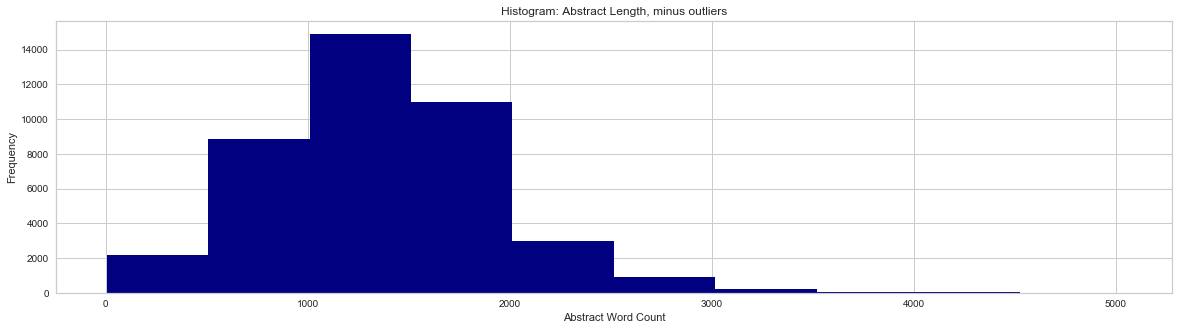

In [12]:
doc_length = docs_length.plot(kind = 'hist', title = 'Histogram: Abstract Length, minus outliers', colormap='jet', figsize =(20,5))
doc_length.set_xlabel("Abstract Word Count")
doc_length.set_ylabel("Frequency")

In [13]:
text = text[filtered_entries]
print(len(text))

41099


# Lemmatization/Stop word Reduction

In [14]:
nlp = spacy.load('en_core_web_lg', disable=['tagger','parser','ner'])

In [15]:
def tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or len(word)==1)]

# Vectorize

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
vec = CountVectorizer(tokenizer = tokenizer, max_df=0.80, min_df=3)

In [19]:
cv = vec.fit_transform(text['abstract'])

# Latent Dirichlet Allocation

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
n_components = 20
lda = LatentDirichletAllocation(n_components=n_components,random_state=42)

In [84]:
lda = lda.fit(cv)
lda_doc_dist = lda.transform(cv)

In [23]:
def plot_doc(doc):
    index, value = zip(*[(index, val) for index, val in enumerate(lda_doc_dist[doc])])
    doc_topic_plot = pd.Series(value, index)
    return doc_topic_plot

Text(0, 0.5, 'Topic Proportion')

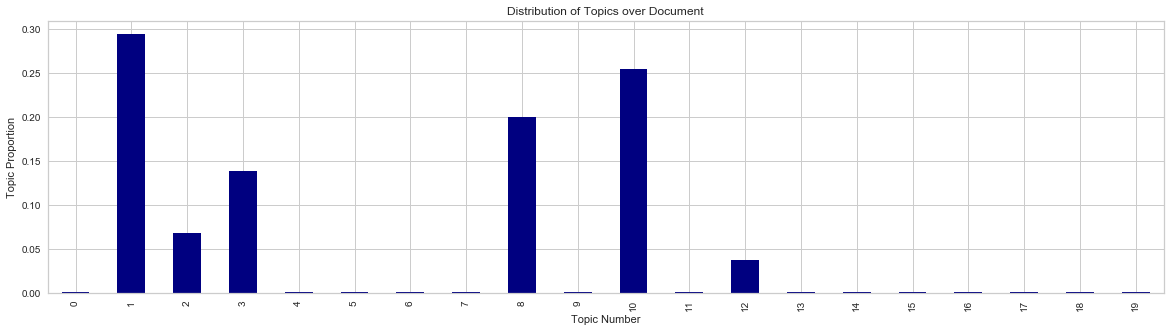

In [24]:
doc = 42
topic_dist_chart = plot_doc(doc).plot(kind = 'bar', title = 'Distribution of Topics over Document', colormap='jet', figsize =(20,5))
topic_dist_chart.set_xlabel("Topic Number")
topic_dist_chart.set_ylabel("Topic Proportion")

In [25]:
text['topic_dist'] = lda_doc_dist.tolist()

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# to similar texts for existing or non-existing texts in the data


In [96]:
new_text = ['this is a sample abstract for the coronavirus text data.']

In [222]:
def similar_text(text_to_compare, n_articles = 10):
    store_vals = list()
    loc =0
    if(isinstance(text_to_compare, list) and len(text_to_compare) is 1):
        new_vec = vec.transform(text_to_compare)
        topic_dist = list(lda.transform(new_vec)[0])
    elif(isinstance(text_to_compare, int)):
        topic_dist = text.loc[text_to_compare, 'topic_dist']
    else:
        raise ValueError
    
    for i in range(len(text)):
        loc +=1
        
        if(i in text.index):
            store_vals.append((i, (sqrt(mean_squared_error(topic_dist, text.loc[i, 'topic_dist'])))))
    most_similar = sorted(store_vals, key=itemgetter(1))
    return [text.loc[i[0]] for i in most_similar[1:n_articles+1]]

In [223]:
similar_text(1)

[cord_uid                                                 4cc2myhl
 title           Molecular detection and characterization of hu...
 abstract        The recently described novel gyroviruses may i...
 publish_time                                           2014-08-14
 authors         Fehér, Enikő; Pazár, Péter; Kovács, Eszter; Fa...
 url             https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
 topic_dist      [0.0008333333515386059, 0.0008333333404027189,...
 topic                                                          10
 Name: 12876, dtype: object,
 cord_uid                                                 55lt9pkc
 title           Cross-Species Transmission in the Speciation o...
 abstract        To gain more insight into the phylogeny of Dab...
 publish_time                                           2012-08-01
 authors         Lin, Xian-Dan; Wang, Wen; Guo, Wen-Ping; Zhang...
 url             https://jvi.asm.org/content/jvi/86/20/11171.fu...
 topic_dist      [0.0004761904825

In [218]:
def similar_text(text_to_compare, n_articles = 10):
    loc = 0
    store_vals = list()
    topic_dist = list(text.loc[text['cord_uid'] == text_to_compare, 'topic_dist'])[0]
    for uid in text['cord_uid']:
        loc +=1
        print(loc/len(text))
        store_vals.append((uid, (sqrt(mean_squared_error(topic_dist, list(text.loc[text['cord_uid'] == uid, 'topic_dist'])[0])))))
    most_similar = sorted(store_vals, key=itemgetter(1))
    return [text.loc[i[0]] for i in most_similar[1:n_articles+1]]

In [219]:
similar_text('gi6uaa83')

2.4331492250419718e-05
4.8662984500839436e-05
7.299447675125916e-05
9.732596900167887e-05
0.00012165746125209859
0.00014598895350251831
0.00017032044575293802
0.00019465193800335774
0.00021898343025377747
0.00024331492250419717
0.0002676464147546169
0.00029197790700503663
0.00031630939925545636
0.00034064089150587603
0.00036497238375629576
0.0003893038760067155
0.0004136353682571352
0.00043796686050755494
0.00046229835275797467
0.00048662984500839434
0.0005109613372588141
0.0005352928295092338
0.0005596243217596535
0.0005839558140100733
0.000608287306260493
0.0006326187985109127
0.0006569502907613324
0.0006812817830117521
0.0007056132752621718
0.0007299447675125915
0.0007542762597630112
0.000778607752013431
0.0008029392442638507
0.0008272707365142704
0.0008516022287646902
0.0008759337210151099
0.0009002652132655296
0.0009245967055159493
0.000948928197766369
0.0009732596900167887
0.0009975911822672084
0.0010219226745176281
0.0010462541667680479
0.0010705856590184676
0.001094917151268887

0.009367624516411592
0.009391956008662012
0.00941628750091243
0.00944061899316285
0.00946495048541327
0.00948928197766369
0.00951361346991411
0.00953794496216453
0.00956227645441495
0.00958660794666537
0.009610939438915788
0.009635270931166208
0.009659602423416628
0.009683933915667048
0.009708265407917468
0.009732596900167888
0.009756928392418308
0.009781259884668726
0.009805591376919146
0.009829922869169566
0.009854254361419986
0.009878585853670406
0.009902917345920826
0.009927248838171246
0.009951580330421666
0.009975911822672084
0.010000243314922504
0.010024574807172924
0.010048906299423344
0.010073237791673764
0.010097569283924183
0.010121900776174603
0.010146232268425023
0.010170563760675442
0.010194895252925862
0.010219226745176281
0.010243558237426701
0.010267889729677121
0.010292221221927541
0.010316552714177961
0.01034088420642838
0.0103652156986788
0.01038954719092922
0.01041387868317964
0.01043821017543006
0.01046254166768048
0.010486873159930899
0.010511204652181319
0.01053

0.01897856395532738
0.0190028954475778
0.01902722693982822
0.01905155843207864
0.01907588992432906
0.01910022141657948
0.0191245529088299
0.01914888440108032
0.01917321589333074
0.019197547385581156
0.019221878877831576
0.019246210370081996
0.019270541862332416
0.019294873354582836
0.019319204846833256
0.019343536339083676
0.019367867831334096
0.019392199323584516
0.019416530815834936
0.019440862308085356
0.019465193800335776
0.019489525292586195
0.019513856784836615
0.019538188277087035
0.019562519769337452
0.019586851261587872
0.01961118275383829
0.01963551424608871
0.01965984573833913
0.01968417723058955
0.01970850872283997
0.01973284021509039
0.01975717170734081
0.01978150319959123
0.01980583469184165
0.01983016618409207
0.01985449767634249
0.01987882916859291
0.01990316066084333
0.019927492153093748
0.019951823645344167
0.019976155137594587
0.020000486629845007
0.020024818122095427
0.020049149614345847
0.020073481106596267
0.020097812598846687
0.020122144091097107
0.02014647558334

0.028638166378744008
0.028662497870994428
0.028686829363244848
0.028711160855495268
0.028735492347745688
0.028759823839996108
0.028784155332246528
0.028808486824496948
0.028832818316747368
0.028857149808997788
0.028881481301248204
0.028905812793498624
0.028930144285749044
0.028954475777999464
0.028978807270249884
0.029003138762500304
0.029027470254750724
0.029051801747001144
0.029076133239251564
0.029100464731501983
0.029124796223752403
0.029149127716002823
0.029173459208253243
0.029197790700503663
0.029222122192754083
0.0292464536850045
0.02927078517725492
0.02929511666950534
0.02931944816175576
0.02934377965400618
0.0293681111462566
0.02939244263850702
0.02941677413075744
0.02944110562300786
0.02946543711525828
0.0294897686075087
0.02951410009975912
0.02953843159200954
0.02956276308425996
0.02958709457651038
0.029611426068760795
0.029635757561011215
0.029660089053261635
0.029684420545512055
0.029708752037762475
0.029733083530012895
0.029757415022263315
0.029781746514513735
0.02980607

0.038419426263412736
0.03844375775566315
0.038468089247913576
0.03849242074016399
0.038516752232414415
0.03854108372466483
0.038565415216915255
0.03858974670916567
0.038614078201416095
0.03863840969366651
0.038662741185916935
0.03868707267816735
0.038711404170417775
0.03873573566266819
0.03876006715491861
0.03878439864716903
0.03880873013941945
0.03883306163166987
0.03885739312392029
0.03888172461617071
0.03890605610842113
0.03893038760067155
0.03895471909292197
0.03897905058517239
0.03900338207742281
0.03902771356967323
0.03905204506192365
0.03907637655417407
0.03910070804642449
0.039125039538674904
0.03914937103092533
0.039173702523175744
0.03919803401542617
0.03922236550767658
0.03924669699992701
0.03927102849217742
0.03929535998442785
0.03931969147667826
0.03934402296892869
0.0393683544611791
0.039392685953429527
0.03941701744567994
0.039441348937930366
0.03946568043018078
0.0394900119224312
0.03951434341468162
0.03953867490693204
0.03956300639918246
0.03958733789143288
0.039611669

0.04827368062483272
0.04829801211708314
0.04832234360933356
0.04834667510158398
0.0483710065938344
0.04839533808608482
0.04841966957833524
0.048444001070585656
0.04846833256283608
0.048492664055086496
0.04851699554733692
0.048541327039587336
0.04856565853183776
0.048589990024088175
0.0486143215163386
0.048638653008589015
0.04866298450083944
0.048687315993089855
0.04871164748534028
0.048735978977590695
0.04876031046984112
0.048784641962091535
0.04880897345434195
0.048833304946592375
0.04885763643884279
0.048881967931093215
0.04890629942334363
0.048930630915594055
0.04895496240784447
0.048979293900094895
0.04900362539234531
0.049027956884595734
0.04905228837684615
0.049076619869096574
0.04910095136134699
0.049125282853597414
0.04914961434584783
0.04917394583809825
0.04919827733034867
0.04922260882259909
0.04924694031484951
0.04927127180709993
0.04929560329935035
0.04931993479160077
0.04934426628385119
0.04936859777610161
0.04939292926835203
0.04941726076060245
0.04944159225285287
0.04946

KeyboardInterrupt: 

In [156]:
text['topic'] = lda_doc_dist.argmax(axis=1)

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
def paper_by_topic(topic):
    print("---------There are " + str(len(text[text['topic'] == topic])) + " Articles in this topic cluster.---------")
    return text[text['topic'] == topic]['title']

for i in text['topic'].unique():
    paper_by_topic(i)

---------There are 1561 Articles in this topic cluster.---------
---------There are 2198 Articles in this topic cluster.---------
---------There are 1723 Articles in this topic cluster.---------
---------There are 3865 Articles in this topic cluster.---------
---------There are 3697 Articles in this topic cluster.---------
---------There are 1063 Articles in this topic cluster.---------
---------There are 2463 Articles in this topic cluster.---------
---------There are 3987 Articles in this topic cluster.---------
---------There are 2299 Articles in this topic cluster.---------
---------There are 4905 Articles in this topic cluster.---------
---------There are 1630 Articles in this topic cluster.---------
---------There are 2734 Articles in this topic cluster.---------
---------There are 2230 Articles in this topic cluster.---------
---------There are 2049 Articles in this topic cluster.---------
---------There are 1044 Articles in this topic cluster.---------
---------There are 1807 A

In [158]:
count_by_topic = text['topic'].value_counts()

Text(0, 0.5, 'Papers (Qty)')

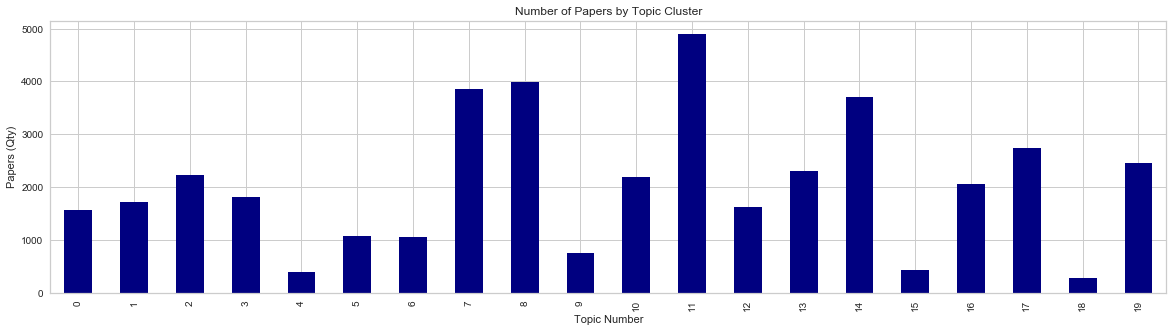

In [159]:
topic_chart = count_by_topic.sort_index().plot(kind = 'bar', title = 'Number of Papers by Topic Cluster', colormap='jet', figsize =(20,5))
topic_chart.set_xlabel("Topic Number")
topic_chart.set_ylabel("Papers (Qty)")

# Visualizations

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer = tokenizer, max_df=0.80, min_df=3)
X = tfidf_vec.fit_transform(text['abstract'])

In [162]:
from sklearn.cluster import KMeans

In [163]:
k_means = KMeans(n_clusters = 20)

In [164]:
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [168]:
kmeans = k_means.transform(X)

In [174]:
y_kmeans = k_means.predict(X)

In [187]:
x = X.todense()

In [408]:
#tsne = TSNEVisualizer()

In [410]:
#tsne.fit(cv, text['topic'])